In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import scipy.io.wavfile
import scipy.signal
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt
import zipfile
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Unzip the collected dataset
zip_path = 'EEGdata_Tripolar.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall()

# Data Pre-Processing

In [ ]:
# Denoising
def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform')
        clf.fit(df_denoised.index.values[:, np.newaxis], df_denoised[col_name])
        y_pred = clf.predict(df_denoised.index.values[:, np.newaxis])
        df_denoised[col_name] = y_pred
        # ax = pd.Series(df[col_name]).plot(color='lightgray')
        # # pd.Series(df["events"]).plot(color='g', ax=ax)
        # pd.Series(y_pred).plot(color='black', ax=ax, figsize=(12, 8))
        # plt.title("Denoising data")

    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()

    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended

    return df_detrended

# Band-pass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def Extract_channel_FreqBands(df):
    channels = df.columns.to_list()
    fs = 250  # Sampling rate
    bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 40)}
    df_new = pd.DataFrame()

    for channel in channels:

        # Filter signal in frequency band of interest
        for i in bands:
            f_low = bands[i][0];
            f_high = bands[i][1];
            x_filt = butter_bandpass_filter(df[channel], f_low, f_high, fs)
            df_new[channel + '_' + i] = x_filt

    return df_new

# Applying the preprocessing functions and concatinating the dataframes
def read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=False):
    eeg_files = glob.glob(os.path.join(path, "eeg/*eeg.csv"))
    event_files = glob.glob(os.path.join(path, "event/*event.csv"))

    eeg_files = sorted(eeg_files)
    event_files = sorted(event_files)

    if FreqBands:
        df = pd.DataFrame(columns=['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                                   'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                                   'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                                   'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma',
                                   'P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                                   'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                                   'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                                   'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma',
                                   'events'])

    else:
        df = pd.DataFrame(columns=['P3_t', 'C3_t', 'C4_t', 'F5_t', 'P3_e', 'C3_e', 'C4_e', 'F5_e', 'events'])

    # loop over the list of csv files
    for eeg, event in zip(eeg_files, event_files):

        # read the csv file
        eeg_df = pd.read_csv(eeg)
        event_df = pd.read_csv(event)

        # Remove spaces
        eeg_df.columns = eeg_df.columns.str.replace(' ', '')

        # Select useful columns
        eeg_df = eeg_df[["FZ", "FC1", "FC2", "C3", "CZ", "C4", "CPZ", "PZ"]]

        # Rename columns
        eeg_df.columns = ['P3_t', 'C3_t', 'C4_t', 'F5_t', 'P3_e', 'C3_e', 'C4_e', 'F5_e']

        # Bandpass filter on raw data
        for column in eeg_df.columns:
            eeg_df[column] = butter_bandpass_filter(eeg_df[column], lowcut=.5, highcut=40, fs=250)

        # Extract FreqBands
        if FreqBands:
            eeg_df = Extract_channel_FreqBands(eeg_df)

        # Z-score
        eeg_df = z_score(eeg_df, list(eeg_df.columns))

        # Detrending
        eeg_df = detrend(eeg_df, list(eeg_df.columns))

        # Denoising
        eeg_df = denoise_data(eeg_df, list(eeg_df.columns), n_clusters=[80]*len(eeg_df.columns))

        # Concat
        df_concat = pd.concat([eeg_df, event_df], axis=1)

        # Remove Nan rows
        df_concat = df_concat.dropna(axis=0)

        # Remove rows with glass_event == 0 (because actually we don't need them)
        df_concat = df_concat[df_concat.glass_event != 0].reset_index()

        # Select usefull columns
        df_concat = df_concat[list(df.columns)]

        # Remove unselected events
        for i in range(3):
            if i not in events:
                df_concat = df_concat[df_concat.events != i]

        df = df.append(df_concat)

    df = df.reset_index()
    df = df.drop('index', axis=1)

    return df

# Data visualization

visualizing one of the trials to see how our data looks like...

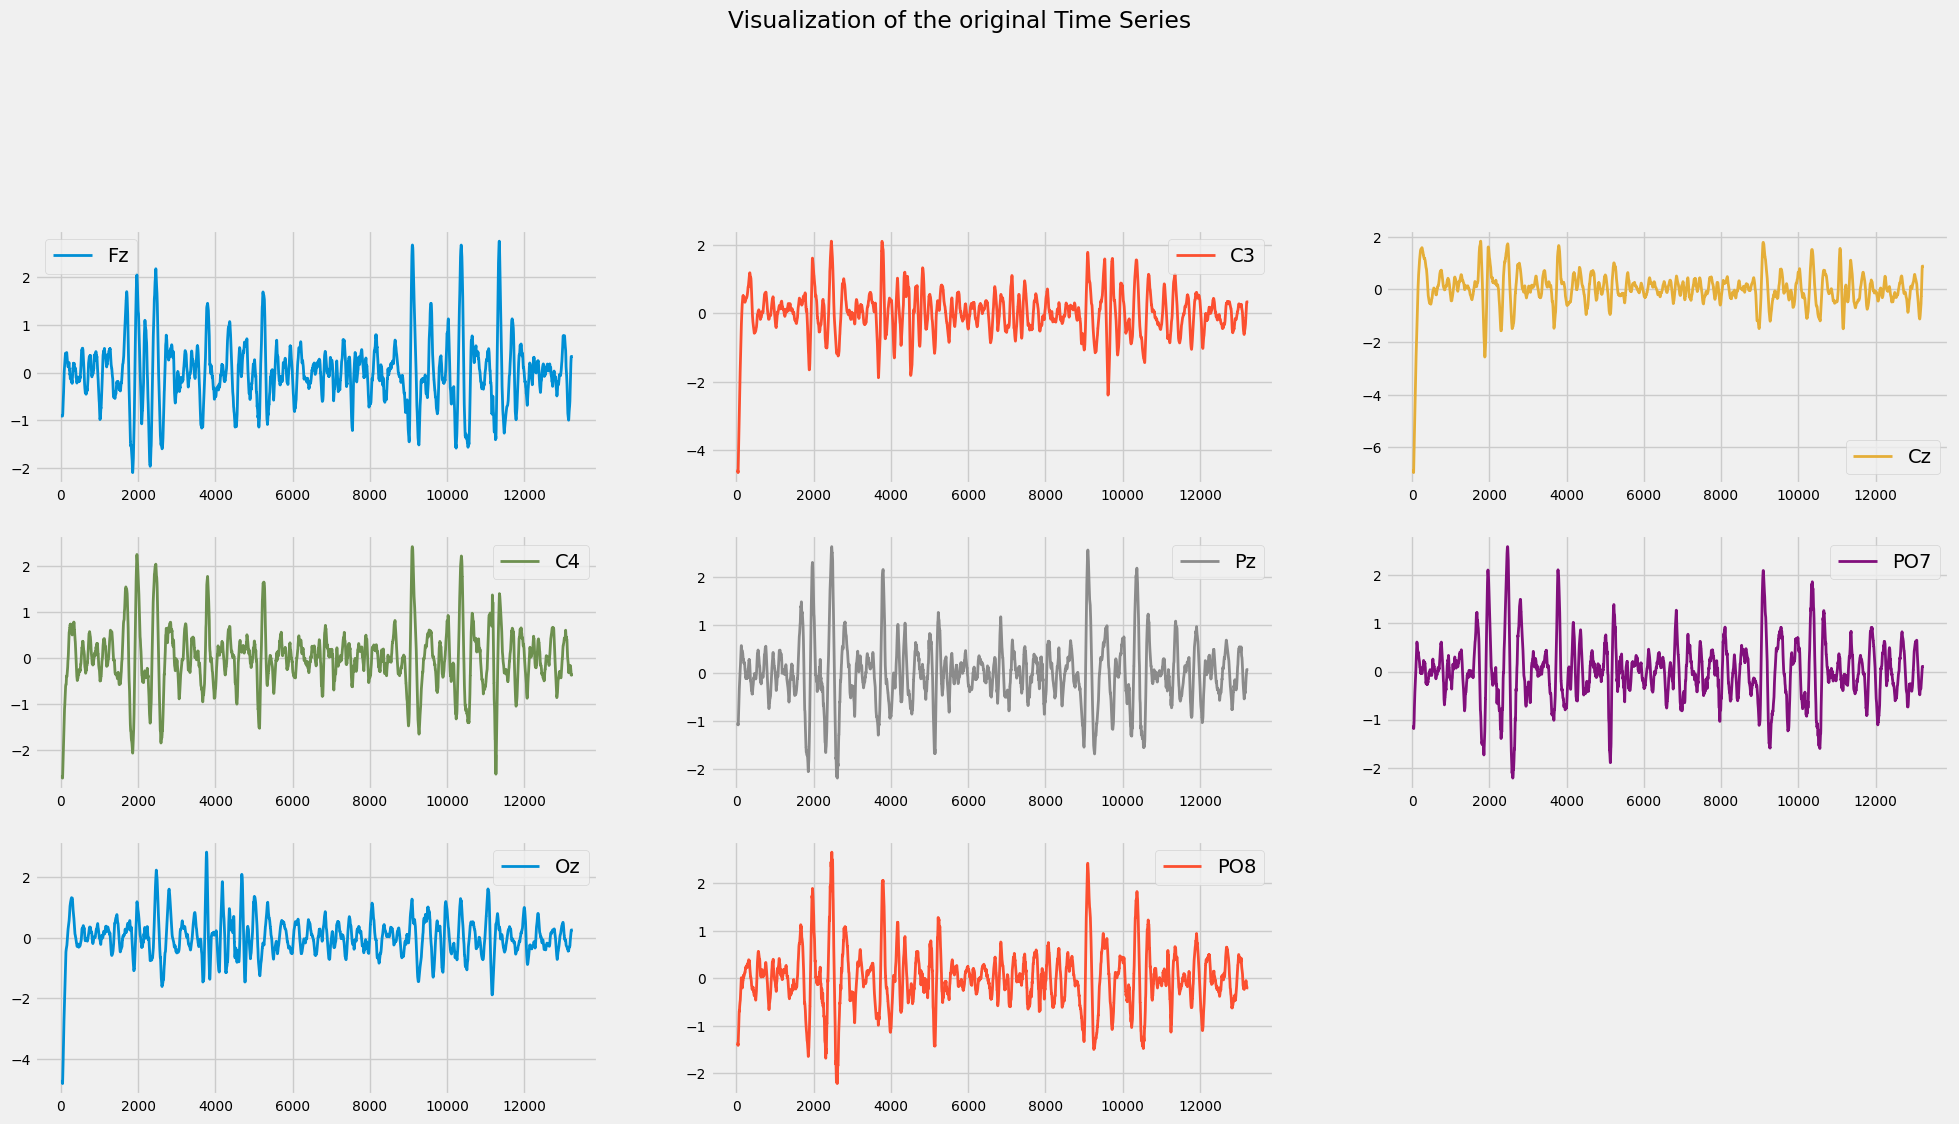

In [ ]:
# Plot the time series
df = pd.read_csv('EEG7.csv')
df.columns = df.columns.str.replace(' ', '')
df = df[["FZ", "FC1", "FC2", "C3", "CZ", "C4", "CPZ", "PZ"]]
df.columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
for column in df.columns:
    df[column] = butter_bandpass_filter(df[column], lowcut=.5, highcut=30, fs=250)

# Z-score
df = z_score(df, list(df.columns))

# Detrending
df = detrend(df, list(df.columns))

# Denoising
df = denoise_data(df, list(df.columns), n_clusters=[80]*len(df.columns))


plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10,
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()


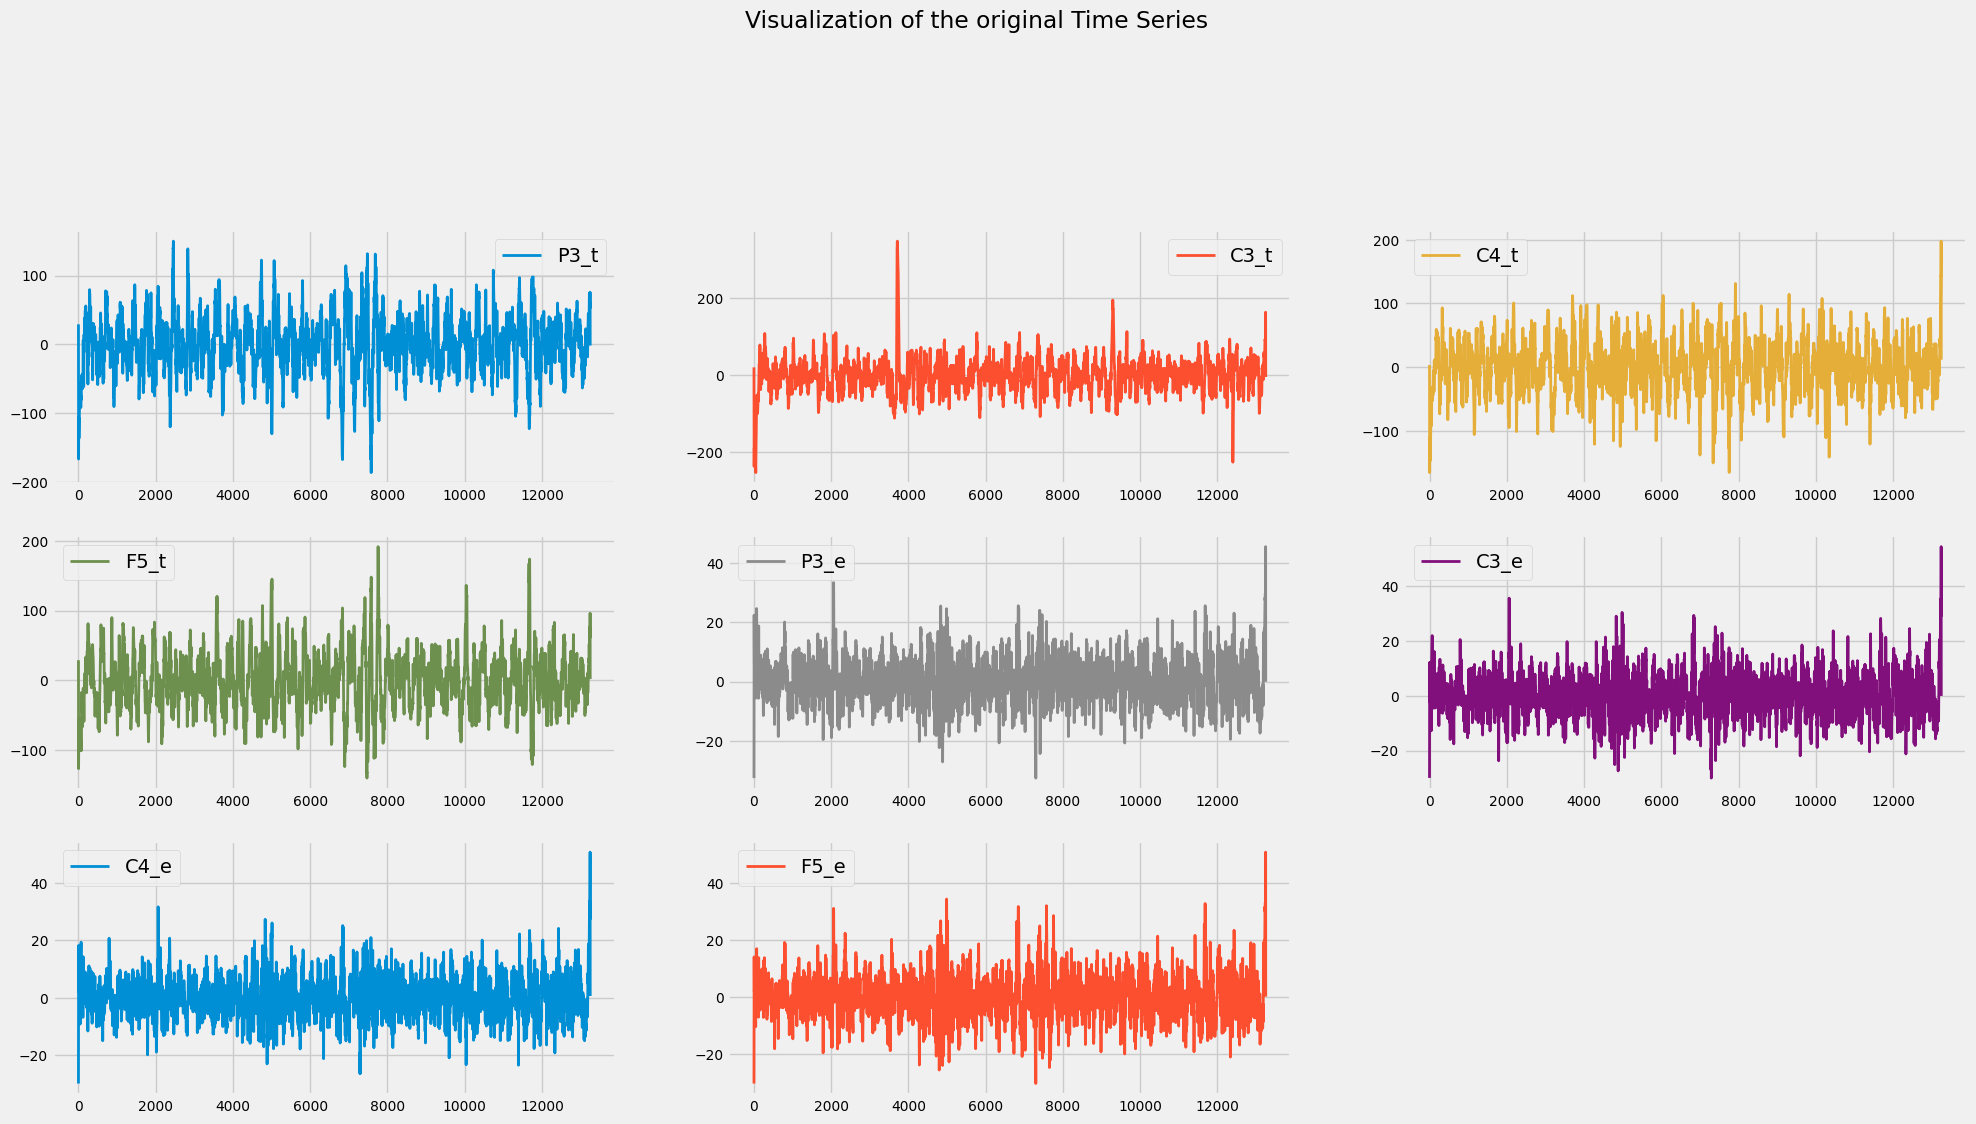

In [ ]:
# Plot the time series
df = pd.read_csv('EEGdata_Tripolar/subject1/task_3/eeg/20230420_152547_eeg.csv')
df.columns = df.columns.str.replace(' ', '')
df = df[["FZ", "FC1", "FC2", "C3", "CZ", "C4", "CPZ", "PZ"]]
df.columns = ['P3_t', 'C3_t', 'C4_t', 'F5_t', 'P3_e', 'C3_e', 'C4_e', 'F5_e']
for column in df.columns:
    df[column] = butter_bandpass_filter(df[column], lowcut=.5, highcut=30, fs=250)

plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10,
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

# Classification

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from deep_learning_models import *

# This function prepare the X_train, X_test, y_train, y_test
def prepare_data(df, win_size=1501):
    X = []
    y = []

    for i in range(0, len(df), win_size):
        x = df[i:i+win_size].values
        X.append(x)
        y.append(labels[i])

    X, y = np.array(X), np.array(y)

    # Shuffle data
    X, y = shuffle(X, y)

    # Balance the dataset
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X.reshape(-1, X.shape[1]*X.shape[2]), y)
    X_resampled = X_resampled.reshape(-1, X.shape[1], X.shape[2])

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42)

    return X_train, X_test, y_train, y_test


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def report_classification_metrics(y_true, y_pred, average_type='macro'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average_type)
    recall = recall_score(y_true, y_pred, average=average_type)
    f1 = f1_score(y_true, y_pred, average=average_type)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [ ]:
# Unzip the collected dataset
zip_path = 'Maryam.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall()

In [ ]:
# Read and Prepare Data
path = "/content/Maryam/task_3"
df = read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=False)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
!pip install torch_geometric

In [ ]:
from torch_geometric.data import Data, DataLoader
import torch

X_train, X_test, y_train, y_test = prepare_data(df_eeg)

train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
import torch
from torch_geometric.data import Data

adj_matrix = np.array([[0, 0, 0, 1],
                       [0, 0, 1, 1],
                       [0, 1, 0, 1],
                       [1, 1, 1, 0]])


# adj_matrix = np.array([[0, 0, 0, 1],
#                        [0, 0, 1, 0],
#                        [0, 1, 0, 0],
#                        [0, 1, 1, 0]])

def create_graph(data, adj_matrix, label):
    x = torch.tensor(data.T, dtype=torch.float)  # Transpose the data so that channels are the first dimension
    edge_index = torch.tensor(np.where(adj_matrix == 1), dtype=torch.long)
    y = torch.tensor([label], dtype=torch.long)
    batch = torch.tensor([0]*data.shape[1], dtype=torch.long)  # Add batch vector with the same batch index for all nodes
    return Data(x=x, edge_index=edge_index, y=y, batch=batch)


train_graphs = [create_graph(instance, adj_matrix, label) for instance, label in zip(X_train, y_train)]
test_graphs = [create_graph(instance, adj_matrix, label) for instance, label in zip(X_test, y_test)]

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.conv4 = GCNConv(256, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(F.log_softmax(x, dim=1), batch)  # Pool the node features using the batch vector
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=1501, num_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()
correct = 0
total = 0
for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)
        correct += pred.eq(data.y).sum().item()
        total += data.y.shape[0]

accuracy = correct / total
print('Test accuracy: {:.4f}'.format(accuracy))

Test accuracy: 0.8393


## Subject_1

### Multiclass Classification

#### Without FreqBands

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject1/task_3"
df = read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=False)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.5439, Validation Accuracy: 0.5238
Epoch 40, Train Accuracy: 0.6053, Validation Accuracy: 0.5714
Epoch 60, Train Accuracy: 0.6404, Validation Accuracy: 0.6667
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.6667
Precision: 0.7005
Recall: 0.7222
F1 Score: 0.6603

Classification Report:
              precision    recall  f1-score   support

           0       0.44      1.00      0.62         4
           1       0.80      0.50      0.62         8
           2       0.86      0.67      0.75         9

    accuracy                           0.67        21
   macro avg       0.70      0.72      0.66        21
weighted avg       0.76      0.67      0.67        21

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.7193, Validation Accuracy: 0.5714
Epoch 40, Train Accuracy: 0.7982, Validation Accuracy: 0.6190
Epoch 60, Train Accuracy: 0.8509, Validation Accuracy: 0.7

In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9123, Validation Accuracy: 0.8571
Epoch 40, Train Accuracy: 0.9649, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 0.9649, Validation Accuracy: 0.8571
1/1 [==============================] - 0s 123ms/step
CNN model results on EEG Data:

Accuracy: 0.8571
Precision: 0.8690
Recall: 0.8571
F1 Score: 0.8601

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.86      0.86      0.86         7
           2       1.00      0.86      0.92         7

    accuracy                           0.86        21
   macro avg       0.87      0.86      0.86        21
weighted avg       0.87      0.86      0.86        21

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.8596, Validation Accuracy: 0.7619
Epoch 40, Train Accuracy: 0.9298, Validation Accuracy: 0.9048
Epoch 60, Train Accuracy: 0.9737, Validation Accuracy: 0.8

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.6053, Validation Accuracy: 0.3333
Epoch 40, Train Accuracy: 0.8596, Validation Accuracy: 0.4762
Epoch 60, Train Accuracy: 0.9298, Validation Accuracy: 0.7143
1/1 [==============================] - 2s 2s/step
RCNN model results on EEG Data:

Accuracy: 0.7143
Precision: 0.7815
Recall: 0.6727
F1 Score: 0.6667

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.90      0.82      0.86        11
           2       0.44      0.80      0.57         5

    accuracy                           0.71        21
   macro avg       0.78      0.67      0.67        21
weighted avg       0.82      0.71      0.72        21

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.7456, Validation Accuracy: 0.7619
Epoch 40, Train Accuracy: 0.9737, Validation Accuracy: 0.9048
Epoch 60, Train Accuracy: 0.9474, Validation Accuracy: 0.9

#### With FreqBands

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject1/task_3"
df = read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=True)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
             'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
             'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
             'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

df_tripolar = df[['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                  'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                  'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                  'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.6053, Validation Accuracy: 0.6190
Epoch 40, Train Accuracy: 0.7632, Validation Accuracy: 0.7143
Epoch 60, Train Accuracy: 0.8772, Validation Accuracy: 0.7143
Epoch 80, Train Accuracy: 0.8596, Validation Accuracy: 0.7619


1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.7619
Precision: 0.7659
Recall: 0.7659
F1 Score: 0.7659

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.75      0.75      0.75         8
           2       0.83      0.83      0.83         6

    accuracy                           0.76        21
   macro avg       0.77      0.77      0.77        21
weighted avg       0.76      0.76      0.76        21

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.6228, Validation Accuracy: 0.6190
Epoch 40, Train Accuracy: 0.7895, Validation Accuracy: 0.6190
Epoch 60, Train Accuracy: 0.8333, Validation Accuracy: 0.8095
Epoch 80, Train Accuracy: 0.9123, Validation Accuracy: 0.9048
1/1 [==============================] - 2s 2s/step
LSTM model results on Tripolar Data:

Accuracy: 0.9048
Precision: 0.9190
Recall: 0.8889
F1 Score: 0.8901



In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9211, Validation Accuracy: 0.8571
Epoch 40, Train Accuracy: 0.9649, Validation Accuracy: 0.9048
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.8571
Epoch 80, Train Accuracy: 1.0000, Validation Accuracy: 0.8095
1/1 [==============================] - 0s 104ms/step
CNN model results on EEG Data:

Accuracy: 0.8095
Precision: 0.7926
Recall: 0.7833
F1 Score: 0.7856

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       1.00      0.88      0.93         8
           2       0.78      0.88      0.82         8

    accuracy                           0.81        21
   macro avg       0.79      0.78      0.79        21
weighted avg       0.82      0.81      0.81        21

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9561, Validation Accuracy: 0.8571
Epoch 40, Train Accuracy: 0.9649, Validation Accuracy: 0.8

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.6491, Validation Accuracy: 0.6667
Epoch 40, Train Accuracy: 0.8509, Validation Accuracy: 0.7143
Epoch 60, Train Accuracy: 0.9298, Validation Accuracy: 0.7143
Epoch 80, Train Accuracy: 0.9561, Validation Accuracy: 0.7143
1/1 [==============================] - 1s 1s/step
RCNN model results on EEG Data:

Accuracy: 0.7143
Precision: 0.7460
Recall: 0.7407
F1 Score: 0.7099

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.67      1.00      0.80         6
           2       0.57      0.67      0.62         6

    accuracy                           0.71        21
   macro avg       0.75      0.74      0.71        21
weighted avg       0.78      0.71      0.71        21

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.8070, Validation Accuracy: 0.6667
Epoch 40, Train Accuracy: 0.9035, Validation Accuracy: 0.7

### Binary Classification

#### Without FreqBands

##### Classification between bottle and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject1/task_3"
df = read_data_and_preprocessing(path, events=[0, 1], FreqBands=False)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred_labels = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.7237, Validation Accuracy: 0.7857
Epoch 40, Train Accuracy: 0.7763, Validation Accuracy: 0.7143
Epoch 60, Train Accuracy: 0.7632, Validation Accuracy: 0.7143
1/1 [==============================] - 2s 2s/step
LSTM model results on EEG Data:

Accuracy: 0.7143
Precision: 0.7778
Recall: 0.7778
F1 Score: 0.7143

Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      0.56      0.71         9

    accuracy                           0.71        14
   macro avg       0.78      0.78      0.71        14
weighted avg       0.84      0.71      0.71        14

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.7632, Validation Accuracy: 0.9286
Epoch 40, Train Accuracy: 0.7368, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 0.9211, Validation Accuracy: 0.8571
1/1 [==============================] - 3s 3s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9868, Validation Accuracy: 0.7857
Epoch 40, Train Accuracy: 0.9868, Validation Accuracy: 0.6429
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.7857
1/1 [==============================] - 0s 97ms/step
CNN model results on EEG Data:

Accuracy: 0.7857
Precision: 0.7889
Recall: 0.7708
F1 Score: 0.7754

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.78      0.88      0.82         8

    accuracy                           0.79        14
   macro avg       0.79      0.77      0.78        14
weighted avg       0.79      0.79      0.78        14

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9737, Validation Accuracy: 0.9286
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9286
1/1 [==============================] - 0s 98ms/step

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.8158, Validation Accuracy: 0.7857
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.8571
1/1 [==============================] - 1s 1s/step
CNN model results on EEG Data:

Accuracy: 0.8571
Precision: 0.8750
Recall: 0.8750
F1 Score: 0.8571

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.75      1.00      0.86         6

    accuracy                           0.86        14
   macro avg       0.88      0.88      0.86        14
weighted avg       0.89      0.86      0.86        14

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9342, Validation Accuracy: 0.8571
Epoch 40, Train Accuracy: 0.9737, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.8571
1/1 [==============================] - 1s 1s/step
C

##### Classification between pen and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject1/task_3"
df = read_data_and_preprocessing(path, events=[0, 2], FreqBands=False)
df['events'] = df['events'].replace(2, 1)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred_labels = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.8026, Validation Accuracy: 0.6429
Epoch 40, Train Accuracy: 0.8026, Validation Accuracy: 0.6429
Epoch 60, Train Accuracy: 0.8026, Validation Accuracy: 0.7857
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.7857
Precision: 0.7917
Recall: 0.7857
F1 Score: 0.7846

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.83      0.71      0.77         7

    accuracy                           0.79        14
   macro avg       0.79      0.79      0.78        14
weighted avg       0.79      0.79      0.78        14

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.8816, Validation Accuracy: 0.9286
Epoch 40, Train Accuracy: 0.7632, Validation Accuracy: 0.6429
Epoch 60, Train Accuracy: 0.8421, Validation Accuracy: 0.9286
1/1 [==============================] - 1s 1s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9737, Validation Accuracy: 0.8571
Epoch 40, Train Accuracy: 0.9605, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.8571
1/1 [==============================] - 0s 102ms/step
CNN model results on EEG Data:

Accuracy: 0.8571
Precision: 0.8444
Recall: 0.8444
F1 Score: 0.8444

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.80      0.80      0.80         5

    accuracy                           0.86        14
   macro avg       0.84      0.84      0.84        14
weighted avg       0.86      0.86      0.86        14

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9868, Validation Accuracy: 1.0000
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9286
1/1 [==============================] - 0s 177ms/st

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.8947, Validation Accuracy: 0.9286
Epoch 40, Train Accuracy: 0.9737, Validation Accuracy: 0.9286
Epoch 60, Train Accuracy: 0.9737, Validation Accuracy: 0.9286
1/1 [==============================] - 1s 1s/step
CNN model results on EEG Data:

Accuracy: 0.9286
Precision: 0.9286
Recall: 0.9375
F1 Score: 0.9282

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.86      1.00      0.92         6

    accuracy                           0.93        14
   macro avg       0.93      0.94      0.93        14
weighted avg       0.94      0.93      0.93        14

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.8421, Validation Accuracy: 0.7857
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9286
Epoch 60, Train Accuracy: 0.9474, Validation Accuracy: 0.8571
1/1 [==============================] - 1s 1s/step
C

#### With FreqBands

##### Classification between bottle and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject1/task_3"
df = read_data_and_preprocessing(path, events=[0, 1], FreqBands=True)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
             'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
             'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
             'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

df_tripolar = df[['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                  'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                  'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                  'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.7500, Validation Accuracy: 0.5714
Epoch 40, Train Accuracy: 0.8947, Validation Accuracy: 0.5000
Epoch 60, Train Accuracy: 0.8026, Validation Accuracy: 0.7143
Epoch 80, Train Accuracy: 0.9605, Validation Accuracy: 0.7143
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.7143
Precision: 0.8000
Recall: 0.7500
F1 Score: 0.7083

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.60      1.00      0.75         6

    accuracy                           0.71        14
   macro avg       0.80      0.75      0.71        14
weighted avg       0.83      0.71      0.70        14

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.8553, Validation Accuracy: 0.8571
Epoch 40, Train Accuracy: 0.8421, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 0.9079, Validation Accur

In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9737, Validation Accuracy: 0.8571
Epoch 40, Train Accuracy: 0.9868, Validation Accuracy: 0.7857
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9286
Epoch 80, Train Accuracy: 1.0000, Validation Accuracy: 0.9286
1/1 [==============================] - 0s 110ms/step
CNN model results on EEG Data:

Accuracy: 0.9286
Precision: 0.9286
Recall: 0.9375
F1 Score: 0.9282

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.88      0.93         8

    accuracy                           0.93        14
   macro avg       0.93      0.94      0.93        14
weighted avg       0.94      0.93      0.93        14

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9737, Validation Accuracy: 0.7857
Epoch 40, Train Accuracy: 0.9868, Validation Accuracy: 0.7857
Epoch 60, Train Accuracy: 1.0000, Validation Accur

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("RCNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.8553, Validation Accuracy: 0.7857
Epoch 40, Train Accuracy: 0.9737, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 0.9737, Validation Accuracy: 0.8571
Epoch 80, Train Accuracy: 1.0000, Validation Accuracy: 0.9286
1/1 [==============================] - 1s 1s/step
RCNN model results on EEG Data:

Accuracy: 0.9286
Precision: 0.9286
Recall: 0.9375
F1 Score: 0.9282

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.86      1.00      0.92         6

    accuracy                           0.93        14
   macro avg       0.93      0.94      0.93        14
weighted avg       0.94      0.93      0.93        14

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9079, Validation Accuracy: 0.5000
Epoch 40, Train Accuracy: 0.9868, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 1.0000, Validation Accur

##### Classification between pen and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject1/task_3"
df = read_data_and_preprocessing(path, events=[0, 2], FreqBands=True)
df['events'] = df['events'].replace(2, 1)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
             'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
             'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
             'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

df_tripolar = df[['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                  'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                  'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                  'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred_labels = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.7763, Validation Accuracy: 0.7143
Epoch 40, Train Accuracy: 0.8684, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 0.8421, Validation Accuracy: 0.7143
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.7143
Precision: 0.7292
Recall: 0.7292
F1 Score: 0.7143

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.62      0.83      0.71         6

    accuracy                           0.71        14
   macro avg       0.73      0.73      0.71        14
weighted avg       0.74      0.71      0.71        14

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.8026, Validation Accuracy: 0.7143
Epoch 40, Train Accuracy: 0.9211, Validation Accuracy: 0.9286
Epoch 60, Train Accuracy: 0.9079, Validation Accuracy: 0.8571
1/1 [==============================] - 1s 1s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9605, Validation Accuracy: 1.0000
Epoch 40, Train Accuracy: 0.9342, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.8571
1/1 [==============================] - 0s 153ms/step
CNN model results on EEG Data:

Accuracy: 0.8571
Precision: 0.8889
Recall: 0.8571
F1 Score: 0.8542

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.78      1.00      0.88         7

    accuracy                           0.86        14
   macro avg       0.89      0.86      0.85        14
weighted avg       0.89      0.86      0.85        14

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.8947, Validation Accuracy: 0.9286
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 0.9868, Validation Accuracy: 0.8571
1/1 [==============================] - 0s 121ms/st

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.8947, Validation Accuracy: 0.7857
Epoch 40, Train Accuracy: 0.9474, Validation Accuracy: 0.8571
Epoch 60, Train Accuracy: 0.9868, Validation Accuracy: 0.8571
1/1 [==============================] - 1s 1s/step
CNN model results on EEG Data:

Accuracy: 0.8571
Precision: 0.8750
Recall: 0.8750
F1 Score: 0.8571

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.75      1.00      0.86         6

    accuracy                           0.86        14
   macro avg       0.88      0.88      0.86        14
weighted avg       0.89      0.86      0.86        14

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.8421, Validation Accuracy: 0.8571
Epoch 40, Train Accuracy: 0.9737, Validation Accuracy: 0.9286
Epoch 60, Train Accuracy: 0.9737, Validation Accuracy: 0.9286
1/1 [==============================] - 1s 1s/step
C

## Subject_2

### Multiclass Classification

#### Without FreqBands

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject2/task_3"
df = read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=False)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.5656, Validation Accuracy: 0.5909
Epoch 40, Train Accuracy: 0.5984, Validation Accuracy: 0.5909
Epoch 60, Train Accuracy: 0.7459, Validation Accuracy: 0.5909
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.5909
Precision: 0.6705
Recall: 0.5833
F1 Score: 0.5703

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.38      0.50      0.43         6
           2       0.64      0.88      0.74         8

    accuracy                           0.59        22
   macro avg       0.67      0.58      0.57        22
weighted avg       0.70      0.59      0.58        22

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.6967, Validation Accuracy: 0.6364
Epoch 40, Train Accuracy: 0.7541, Validation Accuracy: 0.7727
Epoch 60, Train Accuracy: 0.7623, Validation Accuracy: 0.7

In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.8934, Validation Accuracy: 0.9091
Epoch 40, Train Accuracy: 0.9754, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 0.9754, Validation Accuracy: 0.8636
1/1 [==============================] - 0s 118ms/step
CNN model results on EEG Data:

Accuracy: 0.8636
Precision: 0.8889
Recall: 0.9000
F1 Score: 0.8745

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.67      1.00      0.80         6
           2       1.00      1.00      1.00         6

    accuracy                           0.86        22
   macro avg       0.89      0.90      0.87        22
weighted avg       0.91      0.86      0.87        22

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9262, Validation Accuracy: 0.9545
Epoch 40, Train Accuracy: 0.9918, Validation Accuracy: 0.9545
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.6311, Validation Accuracy: 0.6818
Epoch 40, Train Accuracy: 0.8033, Validation Accuracy: 0.6818
Epoch 60, Train Accuracy: 0.8852, Validation Accuracy: 0.9091
1/1 [==============================] - 2s 2s/step
RCNN model results on EEG Data:

Accuracy: 0.9091
Precision: 0.9333
Recall: 0.8889
F1 Score: 0.8963

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.80      1.00      0.89         8
           2       1.00      1.00      1.00         8

    accuracy                           0.91        22
   macro avg       0.93      0.89      0.90        22
weighted avg       0.93      0.91      0.91        22

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.8689, Validation Accuracy: 0.8182
Epoch 40, Train Accuracy: 0.9590, Validation Accuracy: 0.8636
Epoch 60, Train Accuracy: 0.9672, Validation Accuracy: 0.8

#### With FreqBands

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject2/task_3"
df = read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=True)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
             'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
             'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
             'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

df_tripolar = df[['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                  'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                  'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                  'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.6721, Validation Accuracy: 0.6364
Epoch 40, Train Accuracy: 0.7295, Validation Accuracy: 0.7727
Epoch 60, Train Accuracy: 0.8607, Validation Accuracy: 0.8636
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.8636
Precision: 0.8889
Recall: 0.8783
F1 Score: 0.8660

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.86      0.92         7
           2       1.00      0.78      0.88         9

    accuracy                           0.86        22
   macro avg       0.89      0.88      0.87        22
weighted avg       0.91      0.86      0.87        22

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.8197, Validation Accuracy: 0.8182
Epoch 40, Train Accuracy: 0.8934, Validation Accuracy: 0.7727
Epoch 60, Train Accuracy: 0.8607, Validation Accuracy: 0.9

In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.8525, Validation Accuracy: 0.8636
Epoch 40, Train Accuracy: 0.9344, Validation Accuracy: 0.8636
Epoch 60, Train Accuracy: 0.9672, Validation Accuracy: 0.9545
1/1 [==============================] - 0s 107ms/step
CNN model results on EEG Data:

Accuracy: 0.9545
Precision: 0.9667
Recall: 0.9444
F1 Score: 0.9522

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       1.00      1.00      1.00         7
           2       0.90      1.00      0.95         9

    accuracy                           0.95        22
   macro avg       0.97      0.94      0.95        22
weighted avg       0.96      0.95      0.95        22

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.8934, Validation Accuracy: 0.7727
Epoch 40, Train Accuracy: 0.9672, Validation Accuracy: 0.9091
Epoch 60, Train Accuracy: 0.9590, Validation Accuracy: 0.9

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.7213, Validation Accuracy: 0.6818
Epoch 40, Train Accuracy: 0.8852, Validation Accuracy: 0.8636
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.8636
1/1 [==============================] - 1s 1s/step
RCNN model results on EEG Data:

Accuracy: 0.8636
Precision: 0.8926
Recall: 0.8333
F1 Score: 0.8297

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.78      1.00      0.88         7
           2       0.90      1.00      0.95         9

    accuracy                           0.86        22
   macro avg       0.89      0.83      0.83        22
weighted avg       0.89      0.86      0.85        22

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.8934, Validation Accuracy: 0.8636
Epoch 40, Train Accuracy: 0.9836, Validation Accuracy: 0.6818
Epoch 60, Train Accuracy: 0.9836, Validation Accuracy: 0.7

### Binary Classification

#### Without FreqBands

##### Classification between bottle and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject2/task_3"
df = read_data_and_preprocessing(path, events=[0, 1], FreqBands=False)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred_labels = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.7901, Validation Accuracy: 0.6000
Epoch 40, Train Accuracy: 0.8765, Validation Accuracy: 0.8000
Epoch 60, Train Accuracy: 0.9012, Validation Accuracy: 0.8000
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.8000
Precision: 0.8125
Recall: 0.8500
F1 Score: 0.7964

Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.70      0.82        10

    accuracy                           0.80        15
   macro avg       0.81      0.85      0.80        15
weighted avg       0.88      0.80      0.81        15

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.8148, Validation Accuracy: 0.6667
Epoch 40, Train Accuracy: 0.9012, Validation Accuracy: 0.8000
Epoch 60, Train Accuracy: 0.9136, Validation Accuracy: 0.8000
1/1 [==============================] - 1s 1s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9753, Validation Accuracy: 0.9333
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 80, Train Accuracy: 1.0000, Validation Accuracy: 0.9333
1/1 [==============================] - 0s 169ms/step
CNN model results on EEG Data:

Accuracy: 0.9333
Precision: 0.9167
Recall: 0.9500
F1 Score: 0.9282

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.90      0.95        10

    accuracy                           0.93        15
   macro avg       0.92      0.95      0.93        15
weighted avg       0.94      0.93      0.93        15

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9383, Validation Accuracy: 0.8667
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.8000
Epoch 60, Train Accuracy: 1.0000, Validation Accur

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.8395, Validation Accuracy: 0.6667
Epoch 40, Train Accuracy: 0.8642, Validation Accuracy: 0.7333
Epoch 60, Train Accuracy: 0.9383, Validation Accuracy: 0.8667
Epoch 80, Train Accuracy: 0.9136, Validation Accuracy: 0.8667
1/1 [==============================] - 2s 2s/step
CNN model results on EEG Data:

Accuracy: 0.8667
Precision: 0.9167
Recall: 0.8000
F1 Score: 0.8295

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.83      1.00      0.91        10

    accuracy                           0.87        15
   macro avg       0.92      0.80      0.83        15
weighted avg       0.89      0.87      0.86        15

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9630, Validation Accuracy: 0.8667
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 60, Train Accuracy: 1.0000, Validation Accura

##### Classification between pen and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject2/task_3"
df = read_data_and_preprocessing(path, events=[0, 2], FreqBands=False)
df['events'] = df['events'].replace(2, 1)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred_labels = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.7284, Validation Accuracy: 0.6000
Epoch 40, Train Accuracy: 0.7654, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 0.7160, Validation Accuracy: 0.6000
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.6000
Precision: 0.7273
Recall: 0.7000
F1 Score: 0.5982

Classification Report:
              precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       1.00      0.40      0.57        10

    accuracy                           0.60        15
   macro avg       0.73      0.70      0.60        15
weighted avg       0.82      0.60      0.59        15

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.9012, Validation Accuracy: 0.7333
Epoch 40, Train Accuracy: 0.9383, Validation Accuracy: 0.8667
Epoch 60, Train Accuracy: 0.9012, Validation Accuracy: 0.6000
1/1 [==============================] - 2s 2s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9877, Validation Accuracy: 0.9333
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 0.9877, Validation Accuracy: 0.8667
1/1 [==============================] - 0s 99ms/step
CNN model results on EEG Data:

Accuracy: 0.8667
Precision: 0.8889
Recall: 0.8750
F1 Score: 0.8661

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.78      1.00      0.88         7

    accuracy                           0.87        15
   macro avg       0.89      0.88      0.87        15
weighted avg       0.90      0.87      0.87        15

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9753, Validation Accuracy: 0.8667
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9333
1/1 [==============================] - 0s 104ms/ste

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.8272, Validation Accuracy: 0.9333
Epoch 40, Train Accuracy: 0.8889, Validation Accuracy: 0.8667
Epoch 60, Train Accuracy: 0.9877, Validation Accuracy: 0.9333
1/1 [==============================] - 2s 2s/step
CNN model results on EEG Data:

Accuracy: 0.9333
Precision: 0.9500
Recall: 0.9167
F1 Score: 0.9282

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.90      1.00      0.95         9

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9630, Validation Accuracy: 0.9333
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.8667
1/1 [==============================] - 1s 1s/step
C

#### With FreqBands

##### Classification between bottle and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject2/task_3"
df = read_data_and_preprocessing(path, events=[0, 1], FreqBands=True)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
             'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
             'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
             'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

df_tripolar = df[['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                  'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                  'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                  'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.7778, Validation Accuracy: 0.8000
Epoch 40, Train Accuracy: 0.7160, Validation Accuracy: 0.8000
Epoch 60, Train Accuracy: 0.8889, Validation Accuracy: 0.8000
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.8000
Precision: 0.8636
Recall: 0.7857
F1 Score: 0.7847

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.73      1.00      0.84         8

    accuracy                           0.80        15
   macro avg       0.86      0.79      0.78        15
weighted avg       0.85      0.80      0.79        15

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.9012, Validation Accuracy: 0.8667
Epoch 40, Train Accuracy: 0.9383, Validation Accuracy: 0.8000
Epoch 60, Train Accuracy: 0.9630, Validation Accuracy: 0.9333
1/1 [==============================] - 1s 1s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9630, Validation Accuracy: 0.8667
Epoch 40, Train Accuracy: 0.9877, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9333
1/1 [==============================] - 0s 103ms/step
CNN model results on EEG Data:

Accuracy: 0.9333
Precision: 0.9444
Recall: 0.9286
F1 Score: 0.9321

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.89      1.00      0.94         8

    accuracy                           0.93        15
   macro avg       0.94      0.93      0.93        15
weighted avg       0.94      0.93      0.93        15

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9136, Validation Accuracy: 0.8000
Epoch 40, Train Accuracy: 0.9877, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9333
1/1 [==============================] - 0s 99ms/ste

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("RCNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.9506, Validation Accuracy: 0.8667
Epoch 40, Train Accuracy: 0.9383, Validation Accuracy: 0.8667
Epoch 60, Train Accuracy: 0.9012, Validation Accuracy: 0.8667
Epoch 80, Train Accuracy: 0.9383, Validation Accuracy: 0.8667
1/1 [==============================] - 1s 1s/step
RCNN model results on EEG Data:

Accuracy: 0.8667
Precision: 0.9167
Recall: 0.8000
F1 Score: 0.8295

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.83      1.00      0.91        10

    accuracy                           0.87        15
   macro avg       0.92      0.80      0.83        15
weighted avg       0.89      0.87      0.86        15

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9383, Validation Accuracy: 0.7333
Epoch 40, Train Accuracy: 0.9630, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 1.0000, Validation Accur

##### Classification between pen and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject2/task_3"
df = read_data_and_preprocessing(path, events=[0, 2], FreqBands=True)
df['events'] = df['events'].replace(2, 1)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
             'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
             'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
             'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

df_tripolar = df[['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                  'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                  'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                  'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred_labels = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.7160, Validation Accuracy: 0.7333
Epoch 40, Train Accuracy: 0.9136, Validation Accuracy: 0.7333
Epoch 60, Train Accuracy: 0.9136, Validation Accuracy: 0.7333
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.7333
Precision: 0.7232
Recall: 0.7500
F1 Score: 0.7222

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.88      0.70      0.78        10

    accuracy                           0.73        15
   macro avg       0.72      0.75      0.72        15
weighted avg       0.77      0.73      0.74        15

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.8395, Validation Accuracy: 0.7333
Epoch 40, Train Accuracy: 0.8519, Validation Accuracy: 0.8000
Epoch 60, Train Accuracy: 0.9012, Validation Accuracy: 0.8667
1/1 [==============================] - 1s 1s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9383, Validation Accuracy: 0.9333
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 60, Train Accuracy: 0.9877, Validation Accuracy: 0.8000
1/1 [==============================] - 0s 102ms/step
CNN model results on EEG Data:

Accuracy: 0.8000
Precision: 0.8846
Recall: 0.7000
F1 Score: 0.7205

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.77      1.00      0.87        10

    accuracy                           0.80        15
   macro avg       0.88      0.70      0.72        15
weighted avg       0.85      0.80      0.77        15

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9630, Validation Accuracy: 1.0000
Epoch 40, Train Accuracy: 0.9506, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 0.9877, Validation Accuracy: 0.8667
1/1 [==============================] - 0s 151ms/st

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.9012, Validation Accuracy: 0.8000
Epoch 40, Train Accuracy: 0.8889, Validation Accuracy: 0.7333
Epoch 60, Train Accuracy: 0.8025, Validation Accuracy: 0.8000
1/1 [==============================] - 1s 1s/step
CNN model results on EEG Data:

Accuracy: 0.8000
Precision: 0.8636
Recall: 0.7857
F1 Score: 0.7847

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.73      1.00      0.84         8

    accuracy                           0.80        15
   macro avg       0.86      0.79      0.78        15
weighted avg       0.85      0.80      0.79        15

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9259, Validation Accuracy: 0.8000
Epoch 40, Train Accuracy: 0.9753, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 0.9753, Validation Accuracy: 0.8667
1/1 [==============================] - 2s 2s/step
C

## Subject_3

### Multiclass Classification

#### Without FreqBands

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject3/task_3"
df = read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=False)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.4881, Validation Accuracy: 0.6333
Epoch 40, Train Accuracy: 0.6071, Validation Accuracy: 0.5000
Epoch 60, Train Accuracy: 0.6488, Validation Accuracy: 0.6333
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.6333
Precision: 0.7071
Recall: 0.6326
F1 Score: 0.6096

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       1.00      0.36      0.53        11
           2       0.45      0.62      0.53         8

    accuracy                           0.63        30
   macro avg       0.71      0.63      0.61        30
weighted avg       0.73      0.63      0.62        30

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.6905, Validation Accuracy: 0.8333
Epoch 40, Train Accuracy: 0.7857, Validation Accuracy: 0.8667
Epoch 60, Train Accuracy: 0.8333, Validation Accuracy: 0.8

In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9048, Validation Accuracy: 0.9667
Epoch 40, Train Accuracy: 0.9464, Validation Accuracy: 0.9667
Epoch 60, Train Accuracy: 0.9702, Validation Accuracy: 0.9667
1/1 [==============================] - 0s 101ms/step
CNN model results on EEG Data:

Accuracy: 0.9667
Precision: 0.9762
Recall: 0.9583
F1 Score: 0.9654

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.93      1.00      0.96        13
           2       1.00      0.88      0.93         8

    accuracy                           0.97        30
   macro avg       0.98      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9286, Validation Accuracy: 1.0000
Epoch 40, Train Accuracy: 0.9464, Validation Accuracy: 0.9667
Epoch 60, Train Accuracy: 0.9107, Validation Accuracy: 0.9

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_multiclass(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.7917, Validation Accuracy: 0.8667
Epoch 40, Train Accuracy: 0.8393, Validation Accuracy: 0.8333
Epoch 60, Train Accuracy: 0.8869, Validation Accuracy: 0.8000
1/1 [==============================] - 2s 2s/step
RCNN model results on EEG Data:

Accuracy: 0.8000
Precision: 0.8368
Recall: 0.8084
F1 Score: 0.8186

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.82      0.75      0.78        12
           2       0.69      0.82      0.75        11

    accuracy                           0.80        30
   macro avg       0.84      0.81      0.82        30
weighted avg       0.81      0.80      0.80        30

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.8214, Validation Accuracy: 0.8667
Epoch 40, Train Accuracy: 0.9702, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 0.9881, Validation Accuracy: 0.9

#### With FreqBands

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject3/task_3"
df = read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=True)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
             'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
             'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
             'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

df_tripolar = df[['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                  'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                  'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                  'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.6964, Validation Accuracy: 0.6333
Epoch 40, Train Accuracy: 0.7500, Validation Accuracy: 0.6667
Epoch 60, Train Accuracy: 0.7857, Validation Accuracy: 0.6667
1/1 [==============================] - 2s 2s/step
LSTM model results on EEG Data:

Accuracy: 0.6667
Precision: 0.6742
Recall: 0.6670
F1 Score: 0.6629

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.82      0.90      0.86        10
           2       0.75      0.55      0.63        11

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.66        30
weighted avg       0.68      0.67      0.67        30

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.7619, Validation Accuracy: 0.6667
Epoch 40, Train Accuracy: 0.9107, Validation Accuracy: 0.8667
Epoch 60, Train Accuracy: 0.8929, Validation Accuracy: 0.8

In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9405, Validation Accuracy: 0.8667
Epoch 40, Train Accuracy: 0.9702, Validation Accuracy: 0.9333
Epoch 60, Train Accuracy: 0.9762, Validation Accuracy: 0.9667
1/1 [==============================] - 0s 103ms/step
CNN model results on EEG Data:

Accuracy: 0.9667
Precision: 0.9630
Recall: 0.9630
F1 Score: 0.9608

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00        13
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.96      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9524, Validation Accuracy: 0.9667
Epoch 40, Train Accuracy: 0.9702, Validation Accuracy: 0.9667
Epoch 60, Train Accuracy: 0.9583, Validation Accuracy: 0.9

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_multiclass(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.8214, Validation Accuracy: 0.6333
Epoch 40, Train Accuracy: 0.9286, Validation Accuracy: 0.8667
Epoch 60, Train Accuracy: 0.9643, Validation Accuracy: 0.9333
1/1 [==============================] - 3s 3s/step
RCNN model results on EEG Data:

Accuracy: 0.9333
Precision: 0.9556
Recall: 0.9167
F1 Score: 0.9286

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.87      1.00      0.93        13
           2       1.00      0.75      0.86         8

    accuracy                           0.93        30
   macro avg       0.96      0.92      0.93        30
weighted avg       0.94      0.93      0.93        30

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9286, Validation Accuracy: 0.9667
Epoch 40, Train Accuracy: 0.9702, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 0.9821, Validation Accuracy: 0.9

### Binary Classification

#### Without FreqBands

##### Classification between bottle and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject3/task_3"
df = read_data_and_preprocessing(path, events=[0, 1], FreqBands=False)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred_labels = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.8661, Validation Accuracy: 0.8000
Epoch 40, Train Accuracy: 0.7857, Validation Accuracy: 0.7500
Epoch 60, Train Accuracy: 0.8929, Validation Accuracy: 0.8000
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.8000
Precision: 0.7917
Recall: 0.7917
F1 Score: 0.7917

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.75      0.75      0.75         8

    accuracy                           0.80        20
   macro avg       0.79      0.79      0.79        20
weighted avg       0.80      0.80      0.80        20

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.8750, Validation Accuracy: 0.7500
Epoch 40, Train Accuracy: 0.8839, Validation Accuracy: 0.8000
Epoch 60, Train Accuracy: 0.8482, Validation Accuracy: 0.8500
1/1 [==============================] - 1s 1s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 1.0000, Validation Accuracy: 0.9000
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9000
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.8500
1/1 [==============================] - 0s 101ms/step
CNN model results on EEG Data:

Accuracy: 0.8500
Precision: 0.8636
Recall: 0.8750
F1 Score: 0.8496

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.73      1.00      0.84         8

    accuracy                           0.85        20
   macro avg       0.86      0.88      0.85        20
weighted avg       0.89      0.85      0.85        20

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9732, Validation Accuracy: 0.8500
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.8500
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.8500
1/1 [==============================] - 0s 101ms/st

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.9286, Validation Accuracy: 0.9000
Epoch 40, Train Accuracy: 0.9821, Validation Accuracy: 0.8500
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9500
1/1 [==============================] - 2s 2s/step
CNN model results on EEG Data:

Accuracy: 0.9500
Precision: 0.9444
Recall: 0.9583
F1 Score: 0.9488

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.89      1.00      0.94         8

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9554, Validation Accuracy: 0.9000
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9500
1/1 [==============================] - 1s 1s/step
C

##### Classification between pen and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject3/task_3"
df = read_data_and_preprocessing(path, events=[0, 2], FreqBands=False)
df['events'] = df['events'].replace(2, 1)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred_labels = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.7411, Validation Accuracy: 0.7000
Epoch 40, Train Accuracy: 0.7768, Validation Accuracy: 0.8000
Epoch 60, Train Accuracy: 0.8750, Validation Accuracy: 0.8000
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.8000
Precision: 0.8000
Recall: 0.7473
F1 Score: 0.7619

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.80      0.57      0.67         7

    accuracy                           0.80        20
   macro avg       0.80      0.75      0.76        20
weighted avg       0.80      0.80      0.79        20

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.8304, Validation Accuracy: 1.0000
Epoch 40, Train Accuracy: 0.7946, Validation Accuracy: 0.8500
Epoch 60, Train Accuracy: 0.9286, Validation Accuracy: 0.8500
1/1 [==============================] - 1s 1s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9911, Validation Accuracy: 0.9500
Epoch 40, Train Accuracy: 0.9911, Validation Accuracy: 0.9500
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9500
1/1 [==============================] - 0s 105ms/step
CNN model results on EEG Data:

Accuracy: 0.9500
Precision: 0.9500
Recall: 0.9545
F1 Score: 0.9499

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9911, Validation Accuracy: 0.9500
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 0.9821, Validation Accuracy: 0.9500
1/1 [==============================] - 0s 346ms/st

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=4).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.8750, Validation Accuracy: 0.7500
Epoch 40, Train Accuracy: 0.9911, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9500
1/1 [==============================] - 1s 1s/step
CNN model results on EEG Data:

Accuracy: 0.9500
Precision: 0.9444
Recall: 0.9583
F1 Score: 0.9488

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.89      1.00      0.94         8

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9375, Validation Accuracy: 0.9000
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 0.9196, Validation Accuracy: 0.9500
1/1 [==============================] - 1s 1s/step
C

#### With FreqBands

##### Classification between bottle and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject3/task_3"
df = read_data_and_preprocessing(path, events=[0, 1], FreqBands=True)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
             'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
             'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
             'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

df_tripolar = df[['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                  'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                  'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                  'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.7143, Validation Accuracy: 0.7500
Epoch 40, Train Accuracy: 0.8571, Validation Accuracy: 0.9000
Epoch 60, Train Accuracy: 0.8482, Validation Accuracy: 0.7500
Epoch 80, Train Accuracy: 0.8661, Validation Accuracy: 0.8500
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.8500
Precision: 0.8500
Recall: 0.8535
F1 Score: 0.8496

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.7589, Validation Accuracy: 0.8500
Epoch 40, Train Accuracy: 0.9196, Validation Accuracy: 0.9000
Epoch 60, Train Accuracy: 0.9107, Validation Accur

In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 1.0000, Validation Accuracy: 0.9000
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9500
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9500
1/1 [==============================] - 0s 101ms/step
CNN model results on EEG Data:

Accuracy: 0.9500
Precision: 0.9375
Recall: 0.9615
F1 Score: 0.9467

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.88      1.00      0.93         7

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9554, Validation Accuracy: 0.9500
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9000
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9000
1/1 [==============================] - 0s 105ms/st

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("RCNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("RCNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.9464, Validation Accuracy: 0.9000
Epoch 40, Train Accuracy: 0.9643, Validation Accuracy: 0.9000
Epoch 60, Train Accuracy: 0.9732, Validation Accuracy: 0.9000
1/1 [==============================] - 1s 1s/step
RCNN model results on EEG Data:

Accuracy: 0.9000
Precision: 0.9000
Recall: 0.9167
F1 Score: 0.8990

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.80      1.00      0.89         8

    accuracy                           0.90        20
   macro avg       0.90      0.92      0.90        20
weighted avg       0.92      0.90      0.90        20

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9643, Validation Accuracy: 0.9000
Epoch 40, Train Accuracy: 0.9911, Validation Accuracy: 0.9000
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9000
1/1 [==============================] - 1s 1s/step


##### Classification between pen and empty

In [ ]:
# Read and Prepare Data
path = "/content/EEGdata_Tripolar/subject3/task_3"
df = read_data_and_preprocessing(path, events=[0, 2], FreqBands=True)
df['events'] = df['events'].replace(2, 1)
# Seperate the inputs and labels
labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)
df_eeg = df[['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
             'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
             'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
             'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

df_tripolar = df[['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                  'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                  'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                  'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

In [ ]:
# LSTM
print("Start Training LSTM on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("LSTM model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training LSTM on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = LSTM_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred_labels = (y_pred >= 0.5).astype(int)
print("LSTM model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training LSTM on EEG Data...

Epoch 20, Train Accuracy: 0.6607, Validation Accuracy: 0.5000
Epoch 40, Train Accuracy: 0.6607, Validation Accuracy: 0.5000
Epoch 60, Train Accuracy: 0.8125, Validation Accuracy: 0.6500
1/1 [==============================] - 1s 1s/step
LSTM model results on EEG Data:

Accuracy: 0.6500
Precision: 0.6548
Recall: 0.6313
F1 Score: 0.6267

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.67      0.44      0.53         9

    accuracy                           0.65        20
   macro avg       0.65      0.63      0.63        20
weighted avg       0.65      0.65      0.64        20

Start Training LSTM on Tripolar Data...

Epoch 20, Train Accuracy: 0.8304, Validation Accuracy: 0.7000
Epoch 40, Train Accuracy: 0.7232, Validation Accuracy: 0.6500
Epoch 60, Train Accuracy: 0.8482, Validation Accuracy: 0.8000
1/1 [==============================] - 1s 1s/step


In [ ]:
# CNN
print("Start Training CNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training CNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = CNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training CNN on EEG Data...

Epoch 20, Train Accuracy: 0.9911, Validation Accuracy: 0.9500
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9500
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9000
1/1 [==============================] - 0s 104ms/step
CNN model results on EEG Data:

Accuracy: 0.9000
Precision: 0.8571
Recall: 0.9333
F1 Score: 0.8810

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.71      1.00      0.83         5

    accuracy                           0.90        20
   macro avg       0.86      0.93      0.88        20
weighted avg       0.93      0.90      0.90        20

Start Training CNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9911, Validation Accuracy: 0.9500
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 0.9000
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9000
1/1 [==============================] - 0s 104ms/st

In [ ]:
# RCNN
print("Start Training RCNN on EEG Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_eeg)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on EEG Data:\n")
report_classification_metrics(y_test, y_pred)

print("Start Training RCNN on Tripolar Data...\n")
X_train, X_test, y_train, y_test = prepare_data(df_tripolar)
model = RCNN_binary(win_size=1501, n_channels=20).build()
print_accuracy_callback = PrintAccuracyCallback()
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[print_accuracy_callback], verbose=0)
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print("CNN model results on Tripolar Data:\n")
report_classification_metrics(y_test, y_pred)

Start Training RCNN on EEG Data...

Epoch 20, Train Accuracy: 0.9554, Validation Accuracy: 0.9000
Epoch 40, Train Accuracy: 0.9643, Validation Accuracy: 0.8500
Epoch 60, Train Accuracy: 0.9554, Validation Accuracy: 0.8000
1/1 [==============================] - 1s 1s/step
CNN model results on EEG Data:

Accuracy: 0.8000
Precision: 0.8462
Recall: 0.8182
F1 Score: 0.7980

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20

Start Training RCNN on Tripolar Data...

Epoch 20, Train Accuracy: 0.9643, Validation Accuracy: 0.9000
Epoch 40, Train Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 60, Train Accuracy: 1.0000, Validation Accuracy: 0.9500
1/1 [==============================] - 3s 3s/step
C